In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.figsize']=(20,5)
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import pyarrow.parquet as pq

In [7]:
def sliderPlot(df1,i):
    fig = px.line(df1, y=df1[i] )
    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ))
    fig.show()

In [8]:
table = pq.read_table('D:/Data_Files/DLMS Load Profile/data.parquet')

# Convert it to a Pandas DataFrame (optional)
dframe = table.to_pandas()
dframe.head(1)
dframe['Kwh']=dframe['Kwh']/1000
dframe['time']=dframe['Clock']

In [9]:
len(dframe)

38366

In [10]:
df1=dframe.groupby('sensor')

In [11]:
lst=[]
for id,datafame in df1:
    df=datafame
    
    #""" type conversion """
    df['Clock']=pd.to_datetime(df['Clock'])
    df.set_index(['Clock'],inplace=True,drop= True)
    #""" Done"""
    
    #'''validation'''
    df = df[df.index >= '2022-11-18 00:00:00']
    # print(len(df))
    filtered_df = df[((df['R_Voltage'] == 0) | (df['Y_Voltage'] == 0) | (df['B_Voltage'] == 0)) & 
                     ((df['R_Current'] == 0) | (df['Y_Current'] == 0) | (df['B_Current'] == 0))]
    filtered_df['Kwh'] = 0
    df.loc[filtered_df.index, :] = filtered_df
    #"""" Validation Done """

    #""" Resample """
    df=df[['Kwh']].resample(rule='1H').sum()
    #""" done """

    seasonal=seasonal_decompose(df['Kwh'],model='additive',period=1)
    # seasonal.plot().suptitle('\n additive',fontsize=12)
    df=pd.concat([seasonal.observed,seasonal.seasonal,seasonal.trend,seasonal.resid],axis=1)
    df.columns=["Kwh","seasonal",'trend','resid']
    # df['resid_s']=df['resid'].rolling(window=24).mean()
    # # df.dropna(inplace=True)
    df['data']=df['Kwh']-(df['seasonal'])#+df['resid_s'])
    # # df['id']=id
    # # df['Kwh_s']=df1['Kwh']-df1['Kwh'].shift(1)
    # # df['kwh_stationary']=df1['Kwh']-df1['Kwh_s']
    # # # filtered_df=df[df['Kwh']<200]
    # # # filtered_df['Kwh'] = 200
    # # # df.loc[filtered_df.index, :] = filtered_df
    # # df['Kwh_r']=df['Kwh'].rolling(window=24).mean()
    # df.dropna(inplace=True)
    mean=df['Kwh'].mean()
# Stationary check
    result=adfuller(df['data'],autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
    # print('p-value:', result[1])
    if result[1]<0.05:
        print('data  is stationary with score', result[1])
        print("")
        #df=df.reset_index()
    
        lst.append(df)
    

ADF Statistic: -3.092472816675171
p-value: 0.027115271913655373
Critical Values: {'1%': -3.4311360271821867, '5%': -2.8618873695445903, '10%': -2.5669548999686436}
data  is stationary with score 0.027115271913655373

ADF Statistic: -3.4522075940697685
p-value: 0.009302764071335222
Critical Values: {'1%': -3.4311703419037864, '5%': -2.8619025321802587, '10%': -2.5669629711901023}
data  is stationary with score 0.009302764071335222



In [12]:
# seasonal.plot()

In [14]:
df1=lst[0]
df2=lst[1]

<Axes: xlabel='Clock'>

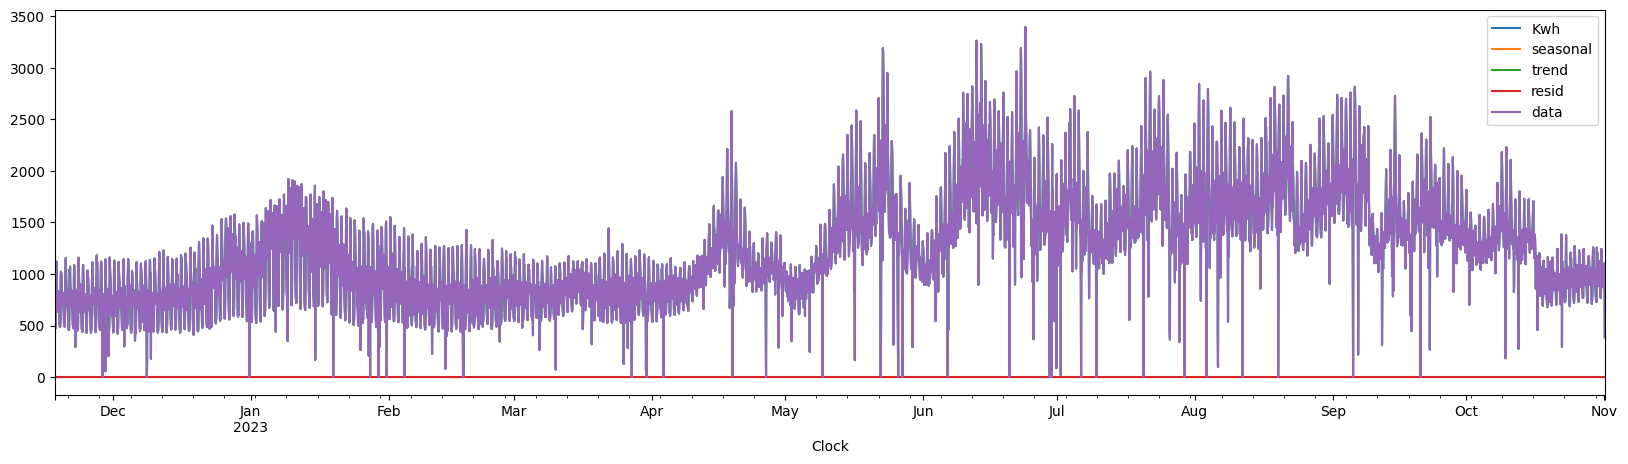

In [15]:
df1.plot()

<Axes: xlabel='Clock'>

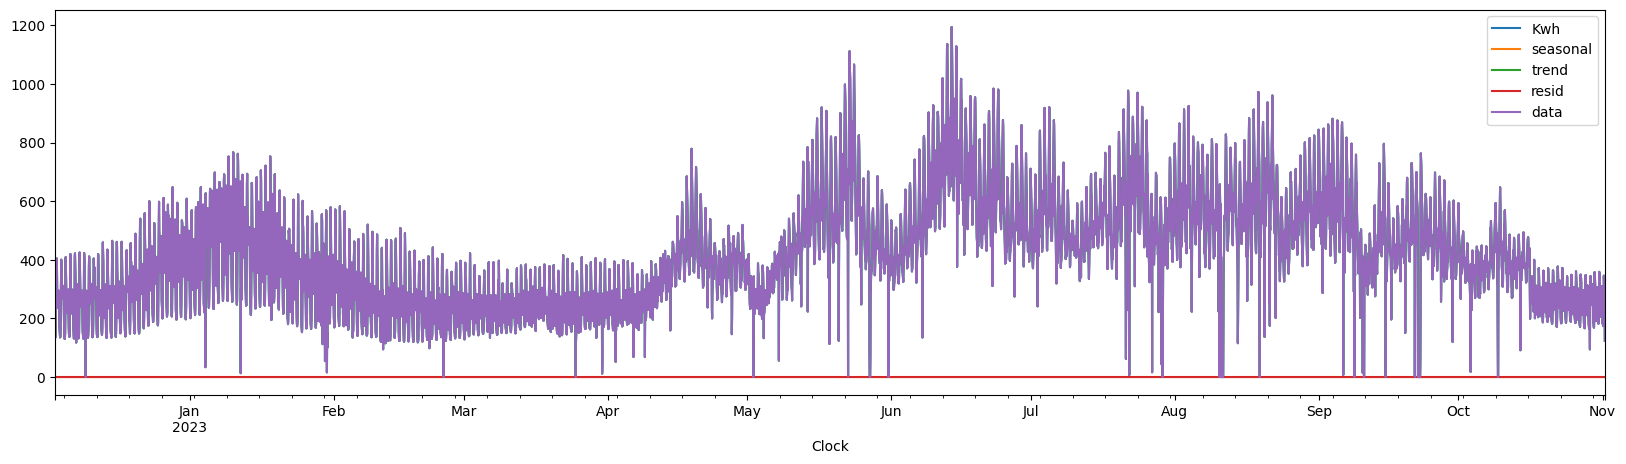

In [16]:
df2.plot()

In [38]:
mean

415.92097439100564

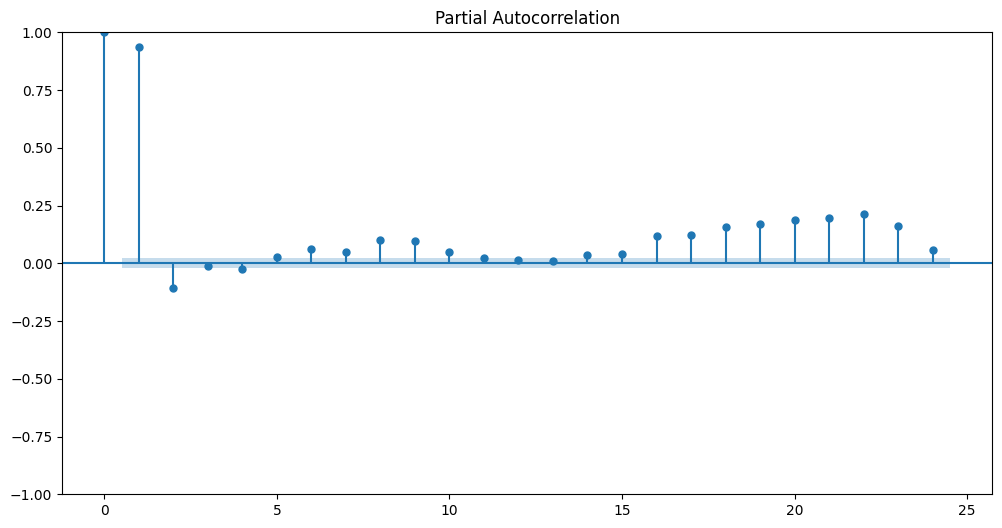

In [27]:
import statsmodels.api as sm

time_series = df['data']

# Compute PACF
pacf_result = sm.tsa.pacf(time_series, nlags=24)

# Plot PACF
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(time_series, lags=24, ax=plt.gca())
plt.show()


<Axes: xlabel='Clock'>

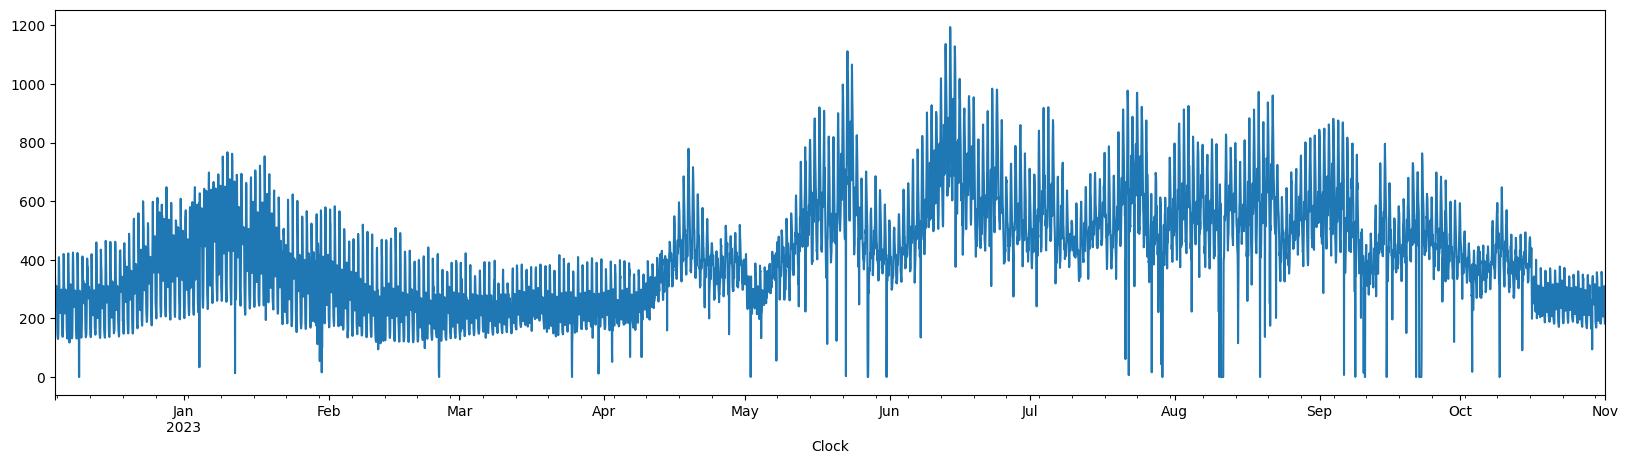

In [17]:
df['Kwh'].plot()

<Axes: xlabel='Clock'>

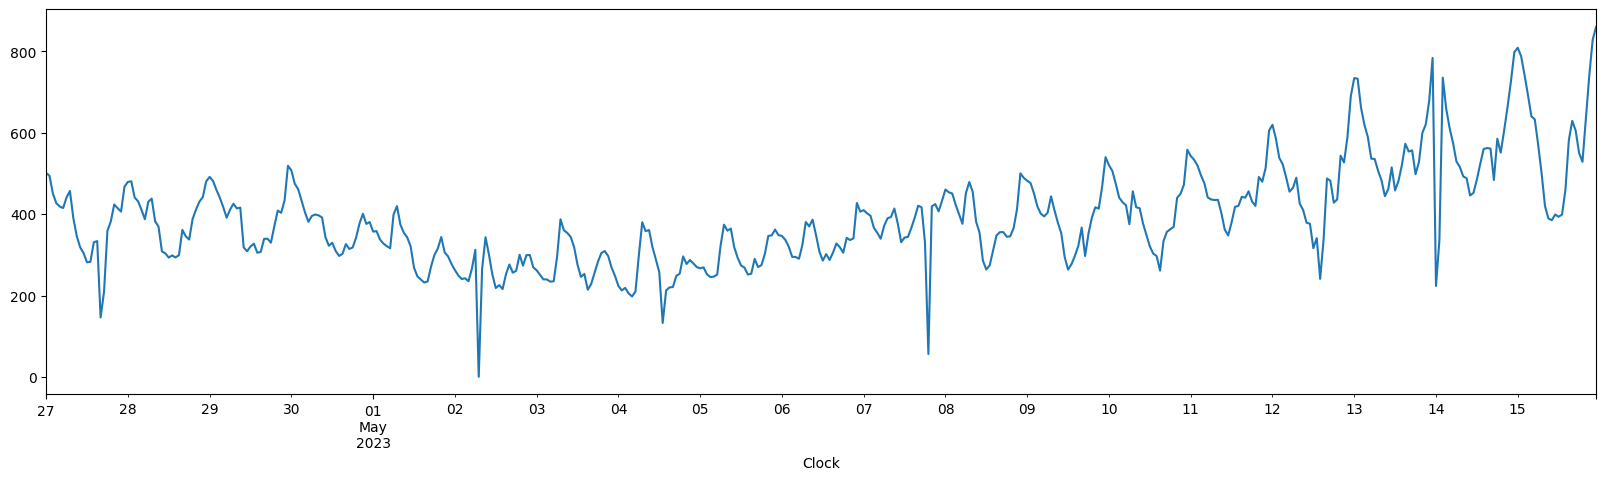

In [20]:
df['Kwh']['27-04-2023':'05-15-2023'].plot()

<Axes: xlabel='Clock'>

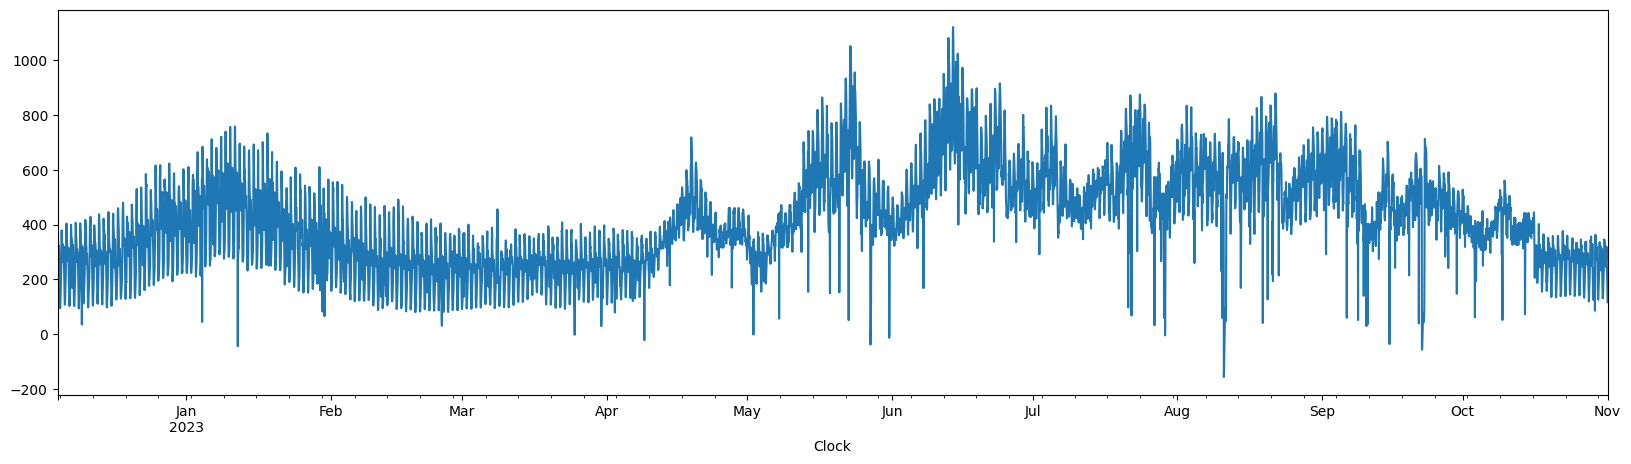

In [16]:
df['data'].plot()

<Axes: xlabel='Clock'>

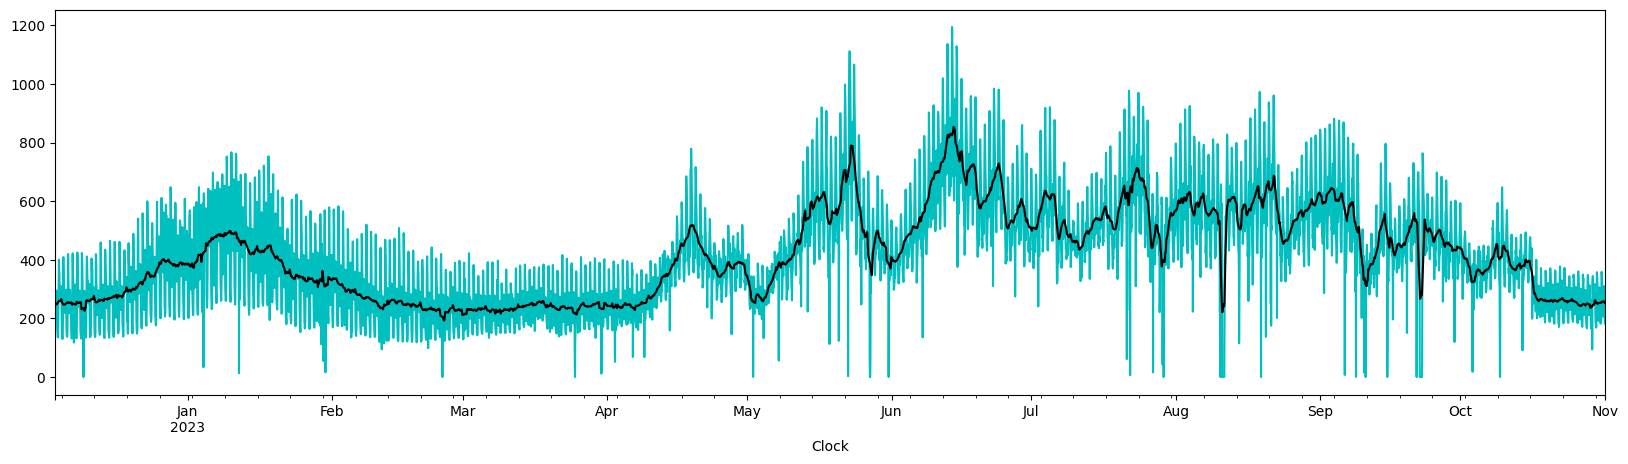

In [30]:
df['Kwh'].plot(c='c')
df['trend'].plot(c='k')

<Axes: xlabel='Clock'>

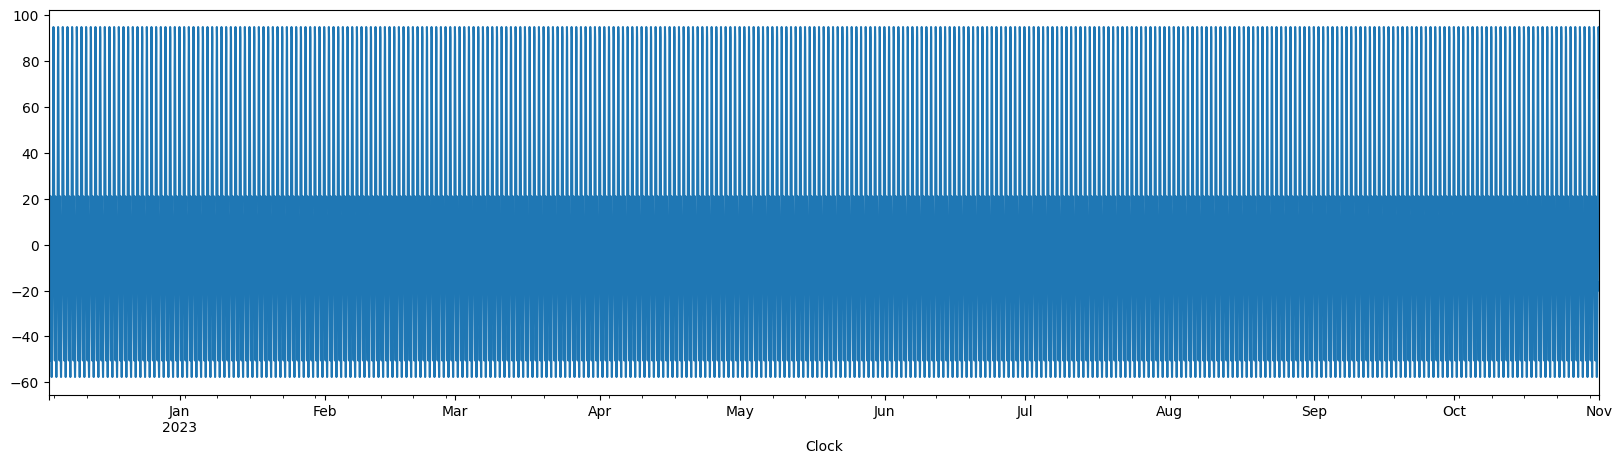

In [74]:
df['seasonal'].plot()

<Axes: xlabel='Clock'>

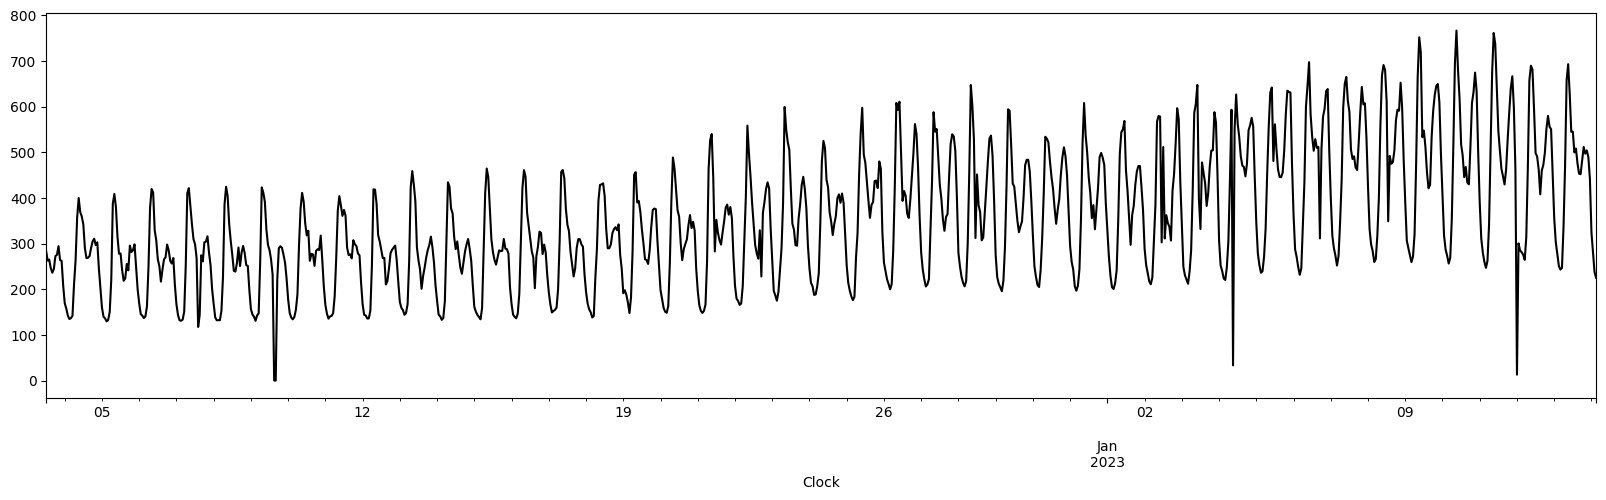

In [31]:
# df['kwh_stationary'][0:1000].plot(c='c')
df['Kwh'][0:1000].plot(c='k')

<Axes: xlabel='Clock'>

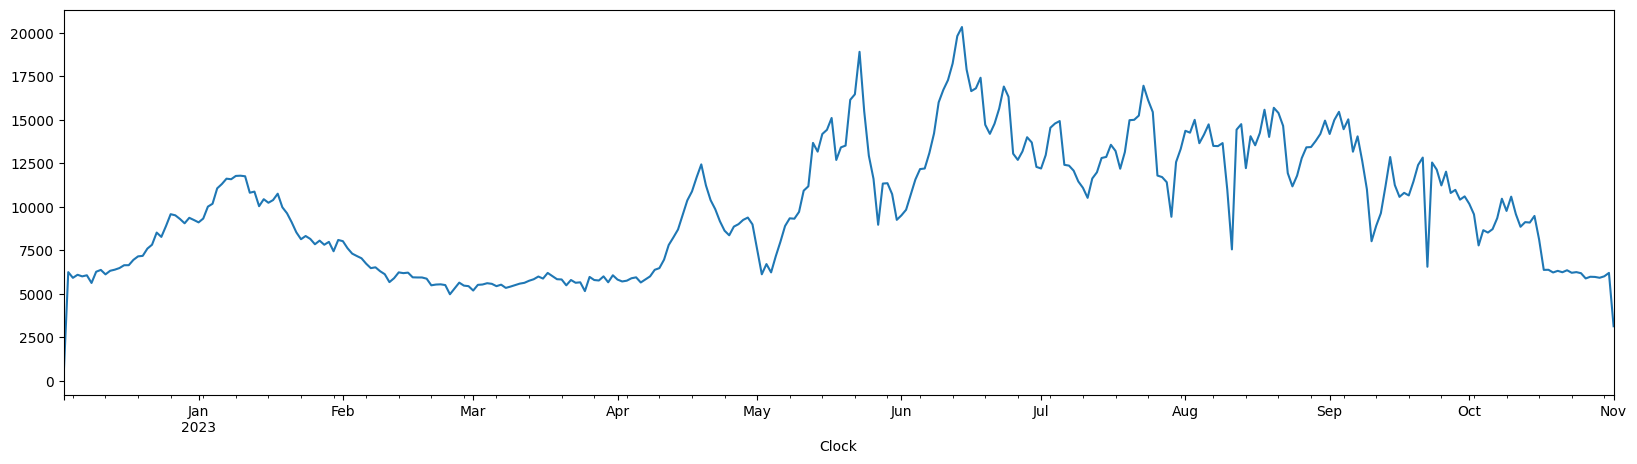

In [65]:
df['Kwh'].resample(rule="1D").sum().plot()

In [27]:
df.describe()

,Kwh,Kwh_s,kwh_stationary,Kwh_r
count,7982.000000,7982.000000,7982.000000,7982.000000
mean,416.399662,-0.017402,416.417063,416.426777
std,183.397593,66.033275,183.376396,147.196991
min,0.000000,-660.300000,0.000000,192.529167
25%,274.200000,-31.375000,274.200000,263.632292
50%,400.300000,-6.000000,400.300000,399.866667
75%,528.600000,26.175000,528.600000,532.953125
max,1194.000000,621.500000,1194.000000,853.075000


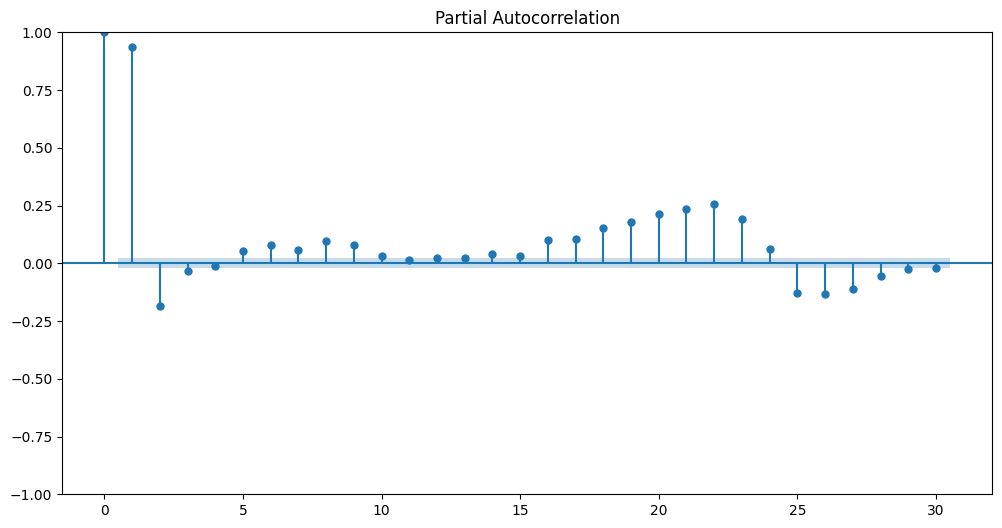

In [23]:
import statsmodels.api as sm

time_series = df['Kwh']

# Compute PACF
pacf_result = sm.tsa.pacf(time_series, nlags=30*24)

# Plot PACF
plt.figure(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(time_series, lags=30, ax=plt.gca())
plt.show()


In [31]:
df.dropna(inplace=True)

In [35]:
df

,Kwh,id,Kwh_s,kwh_stationary,Kwh_r
Clock,,,,,
2022-12-03 23:00:00,208.8,62a9920f75c931.62399458,-53.7,262.5,248.087500
2022-12-04 00:00:00,169.9,62a9920f75c931.62399458,-38.9,208.8,251.579167
2022-12-04 01:00:00,158.0,62a9920f75c931.62399458,-11.9,169.9,251.862500
2022-12-04 02:00:00,142.8,62a9920f75c931.62399458,-15.2,158.0,252.229167
2022-12-04 03:00:00,135.0,62a9920f75c931.62399458,-7.8,142.8,251.845833
...,...,...,...,...,...
2023-11-01 08:00:00,320.8,62a9920f75c931.62399458,-24.9,345.7,256.695833
2023-11-01 09:00:00,337.3,62a9920f75c931.62399458,16.5,320.8,256.479167
2023-11-01 10:00:00,301.5,62a9920f75c931.62399458,-35.8,337.3,255.737500


Axes(0.125,0.11;0.775x0.77)


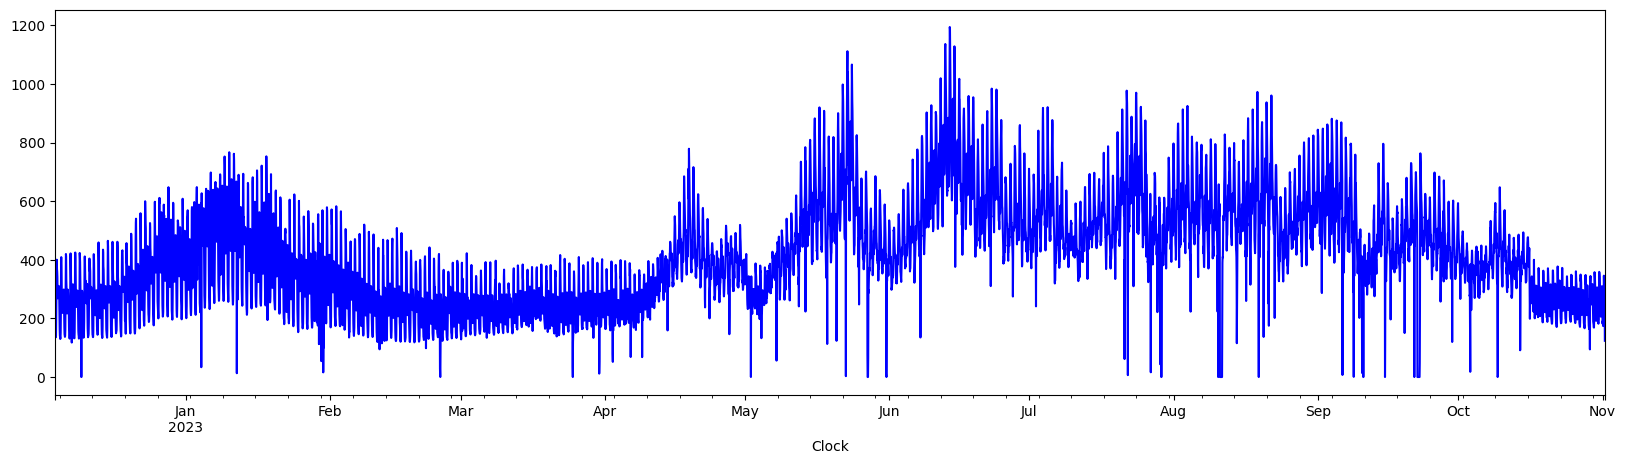

In [38]:
print(df['Kwh'].plot(color='b'))
# df['Kwh_r'].plot(color='k')


Axes(0.125,0.11;0.775x0.77)


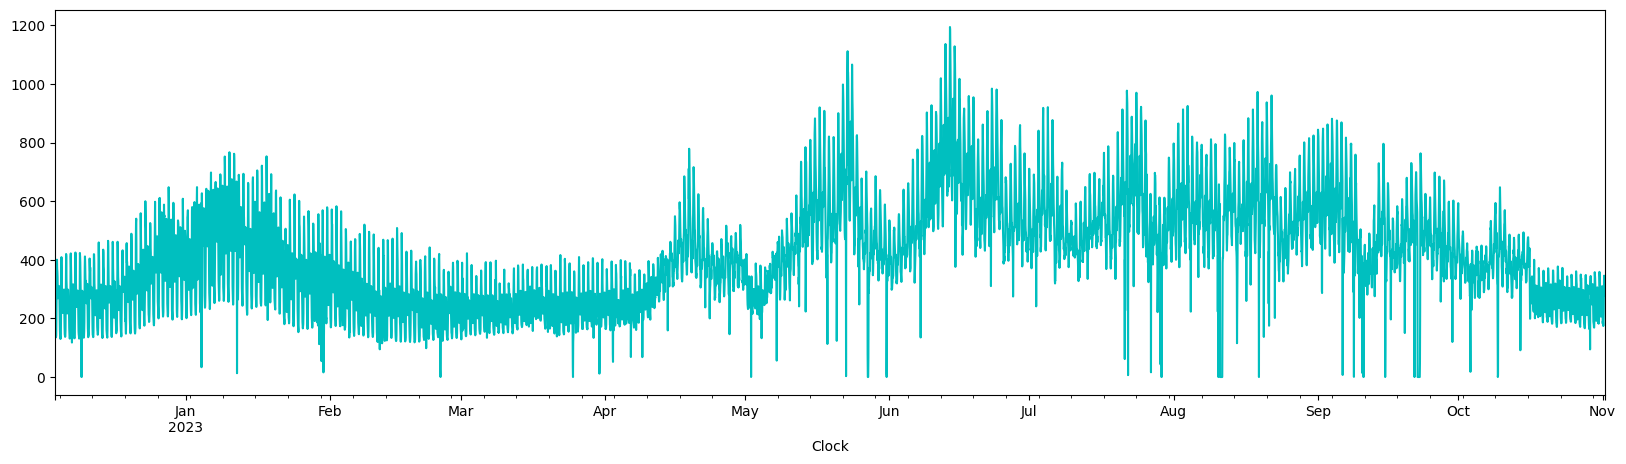

In [39]:
print(df['kwh_stationary'].plot(color='c'))

In [10]:
sliderPlot(df,"Kwh")

In [11]:
df["kwh_new"]=df['Kwh']-df['Kwh'].shift(1)

<Axes: xlabel='Clock'>

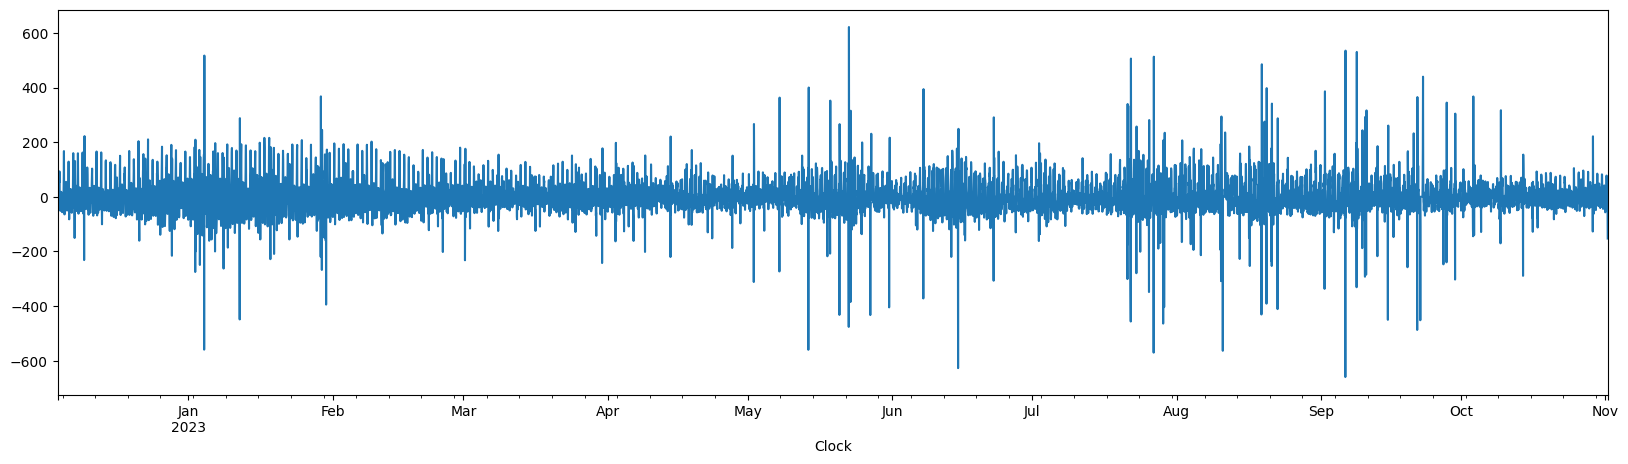

In [12]:
df['kwh_new'].plot()

In [14]:
df.dropna(inplace=True)
result=adfuller(df['kwh_new'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -20.889360194502768
p-value: 0.0
Critical Values: {'1%': -3.431172715688274, '5%': -2.861903581077222, '10%': -2.5669635295294797}


In [15]:
df['data2']=df['Kwh']-df['kwh_new']

<Axes: xlabel='Clock'>

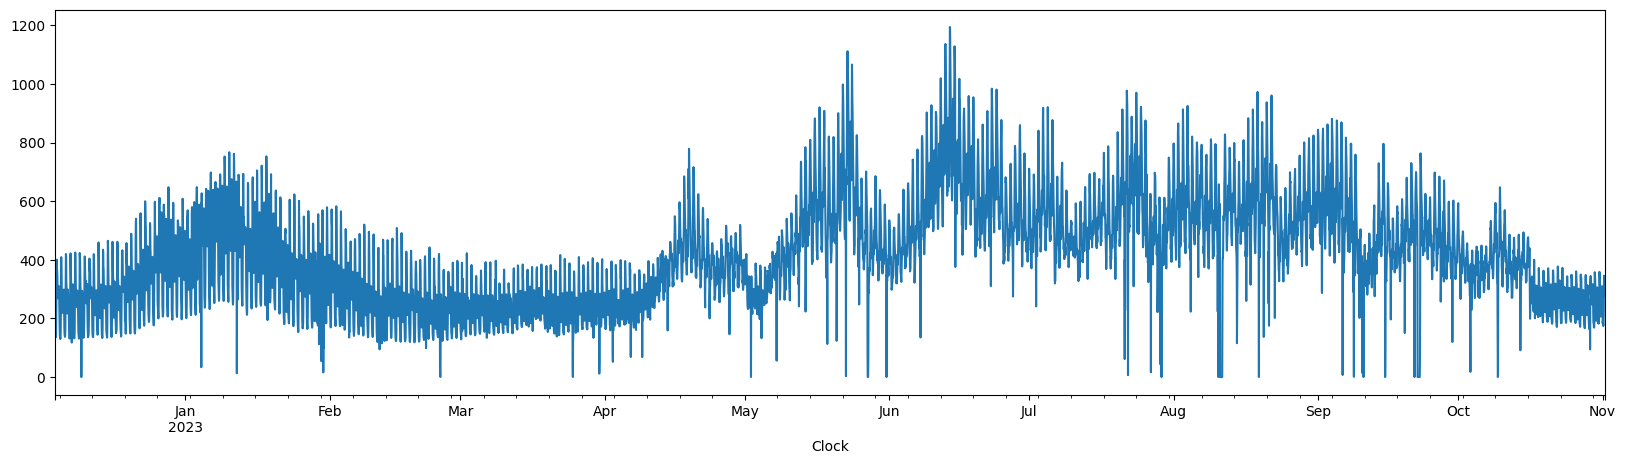

In [16]:
df['data2'].plot()

In [17]:
df.dropna(inplace=True)
result=adfuller(df['data2'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -3.472483526017698
p-value: 0.0087225444453813
Critical Values: {'1%': -3.4311728192079674, '5%': -2.861903626819137, '10%': -2.5669635538784066}


,seasonal,trend,resid,Kwh
Clock,,,,
2022-12-04 00:00:00,64.488051,NaN,NaN,169.9
2022-12-04 01:00:00,35.004050,NaN,NaN,158.0
2022-12-04 02:00:00,5.236144,NaN,NaN,142.8
2022-12-04 03:00:00,-20.378232,NaN,NaN,135.0
2022-12-04 04:00:00,-40.135288,NaN,NaN,136.8
...,...,...,...,...
2023-11-01 08:00:00,20.859048,NaN,NaN,320.8
2023-11-01 09:00:00,7.654680,NaN,NaN,337.3
2023-11-01 10:00:00,-12.716462,NaN,NaN,301.5


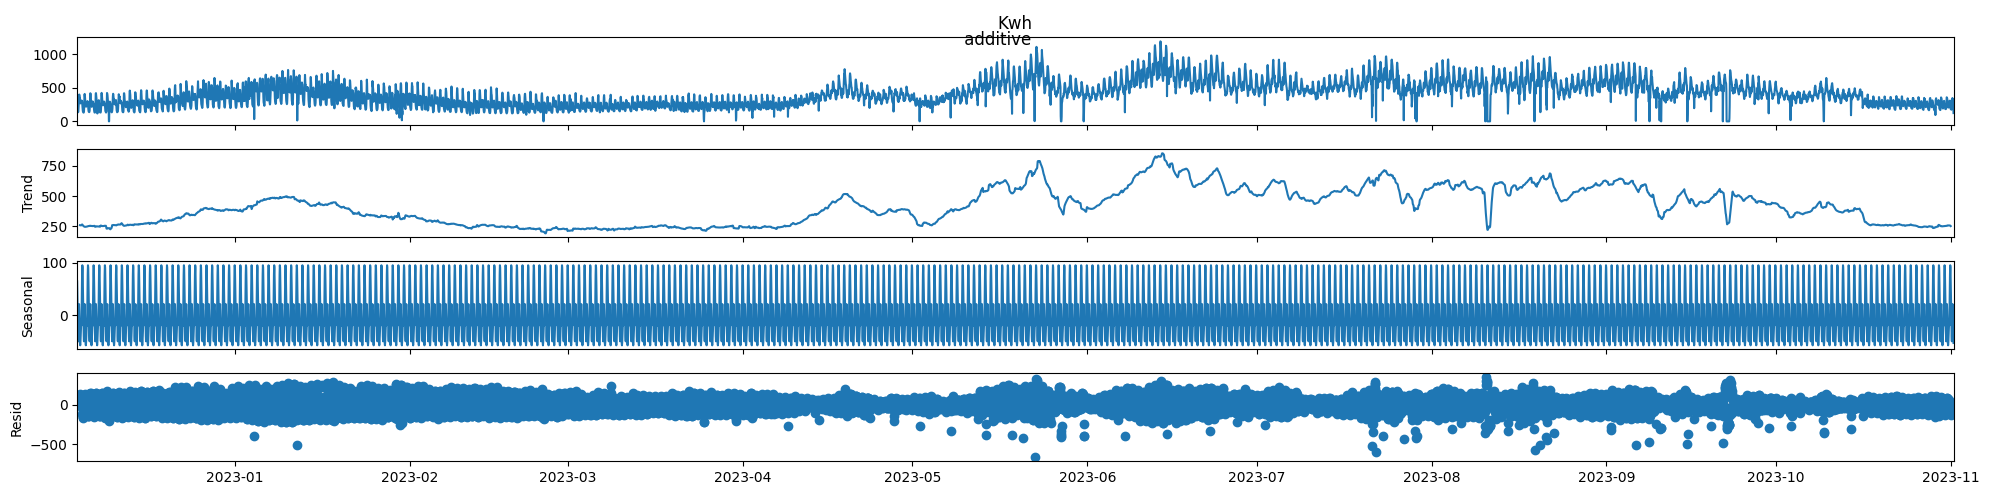

In [100]:
add_resut=seasonal_decompose(df['Kwh'],model='additive',period=24)
add_resut.plot().suptitle('\n additive',fontsize=12)
dfs=pd.concat([add_resut.seasonal,add_resut.trend,add_resut.resid,add_resut.observed],axis=1)
dfs.columns=["seasonal",'trend','resid','Kwh']
dfs

In [101]:
dfs['resid_smooth']=dfs['resid'].rolling(window=24).mean()

<Axes: xlabel='Clock'>

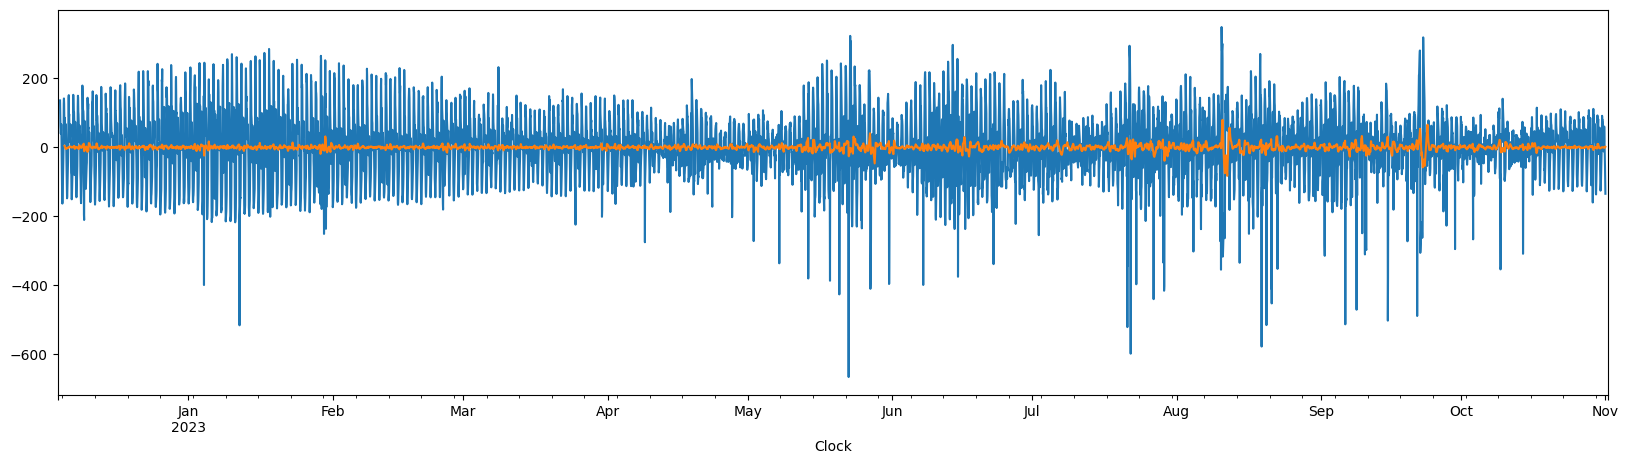

In [102]:
dfs['resid'].plot()
dfs['resid_smooth'].plot()

In [103]:
dfs

,seasonal,trend,resid,Kwh,resid_smooth
Clock,,,,,
2022-12-04 00:00:00,64.488051,NaN,NaN,169.9,NaN
2022-12-04 01:00:00,35.004050,NaN,NaN,158.0,NaN
2022-12-04 02:00:00,5.236144,NaN,NaN,142.8,NaN
2022-12-04 03:00:00,-20.378232,NaN,NaN,135.0,NaN
2022-12-04 04:00:00,-40.135288,NaN,NaN,136.8,NaN
...,...,...,...,...,...
2023-11-01 08:00:00,20.859048,NaN,NaN,320.8,NaN
2023-11-01 09:00:00,7.654680,NaN,NaN,337.3,NaN
2023-11-01 10:00:00,-12.716462,NaN,NaN,301.5,NaN


In [104]:
dfs['s+r']=dfs['resid_smooth']+dfs['seasonal']

<Axes: xlabel='Clock'>

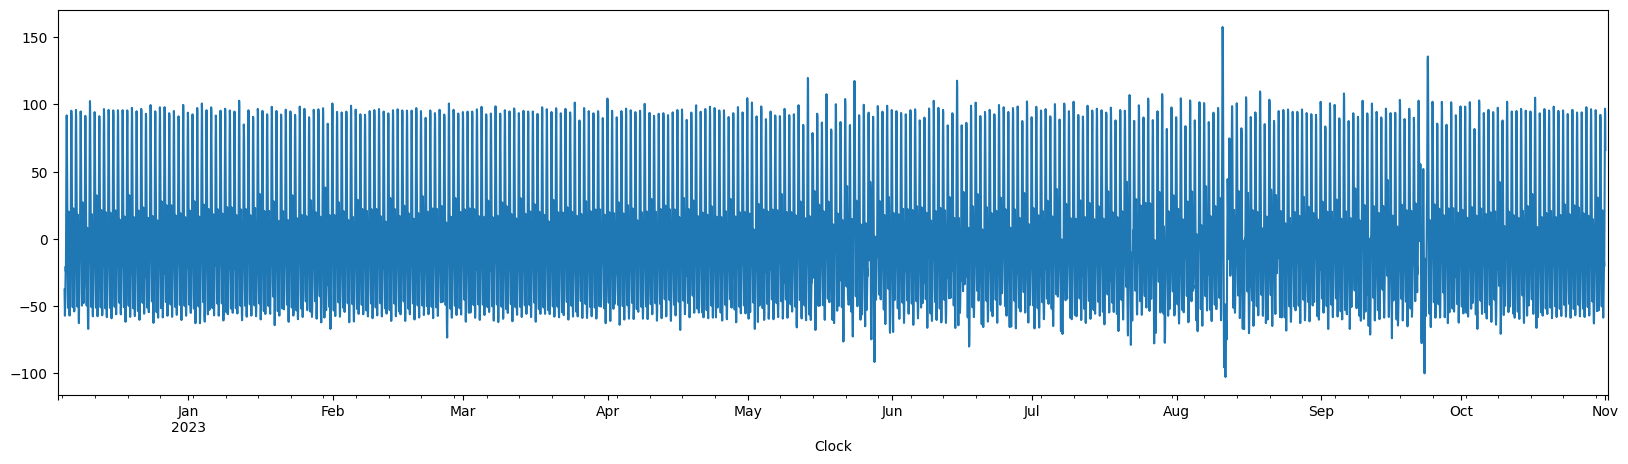

In [105]:
dfs['s+r'].plot()

In [106]:
dfs['s+r+t']=dfs['s+r']+dfs['trend']

In [109]:
dfs.dropna(inplace=True)


In [110]:
result=adfuller(dfs['s+r+t'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -2.554501742431037
p-value: 0.10277008392835663
Critical Values: {'1%': -3.431178343281126, '5%': -2.8619060677212893, '10%': -2.566964853198012}


In [111]:
dfs['data']=dfs['s+r+t'].rolling(window=24).mean()

<Axes: xlabel='Clock'>

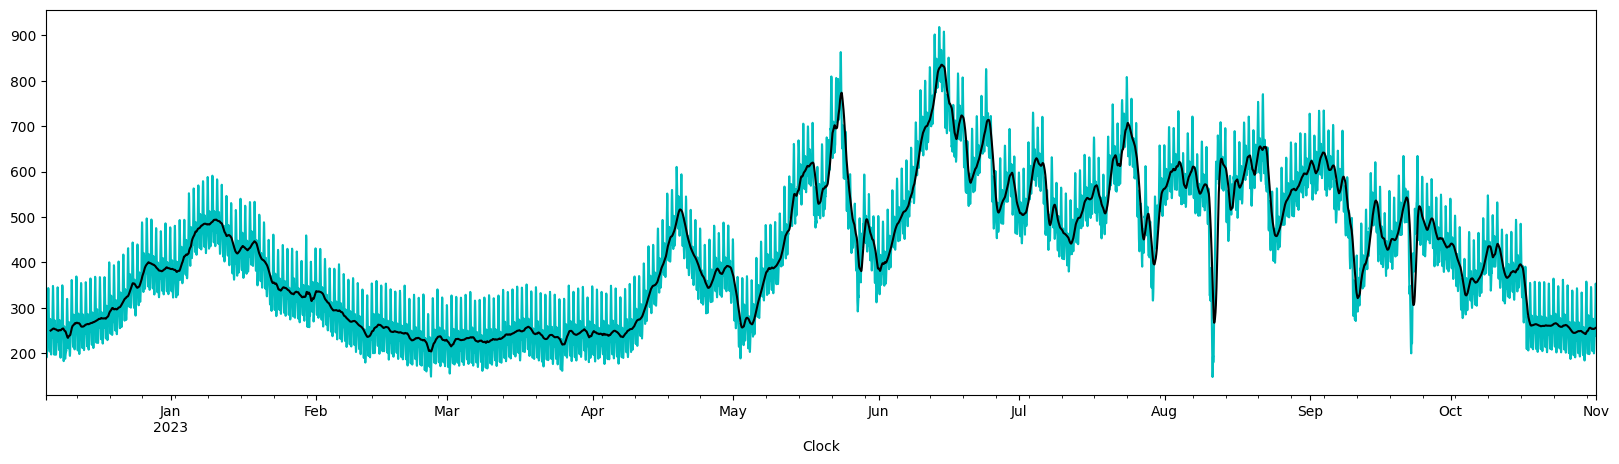

In [112]:
dfs['s+r+t'].plot(color='c')
dfs['data'].plot(color='k')

In [113]:
dfs.dropna(inplace=True)
result=adfuller(dfs['data'],autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -1.9092021489132291
p-value: 0.3277445897011124
Critical Values: {'1%': -3.4311807636661724, '5%': -2.861907137206615, '10%': -2.5669654224972964}


In [114]:
# df[df['Kwh']<=200]

In [ ]:
df['Kwh'].plot(color='c',title="30min, rolling=12 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="30min, rolling=24 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="30min, rolling=12,kwh<50 =100 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="30min, rolling=12,")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="30 min, rolling=24 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="30 min, rolling=48 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="30 min, rolling=24,kwh<50 =100 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="1H, rolling=24,kwh<100 =150 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="1H, rolling=24,kwh<100 =200 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="1H, rolling=24,kwh<100 =250 ")
df['Kwh_r'].plot(color='k')

In [ ]:
df['Kwh'].plot(color='c',title="1H, rolling=12,kwh<100 =150 ")
df['Kwh_r'].plot(color='k')

In [ ]:

print(df['Kwh'].describe())
print()
print(df['Kwh_r'].describe())

result=adfuller(df['Kwh'],autolag='AIC')
print("kwh",'p-value:', result[1])

result=adfuller(df['Kwh_r'],autolag='AIC')
print("kwh_r",'p-value:', result[1])

